# Unified BDSL-SPOTER Training Notebook

**Overview**: This notebook consolidates all scattered code from the BDSLW_SPOTER project into a single, production-ready training pipeline with WandB tracking.

**Dataset**: Bengali Sign Language (BdSL) with 72 words, 833 videos from 3 signers (S01, S02, S05)

**Model**: ProductionSPOTER - Transformer-based architecture optimized for sign language recognition

**Features**:
- Full WandB integration for experiment tracking
- Proper train/val/test splits (665/82/86)
- 108D pose features (33 landmarks × 3 coords + padding)
- 150 frames max sequence length
- Data augmentation (temporal, spatial, perspective)
- Mixed precision training
- Early stopping with checkpointing
- Comprehensive evaluation (per-signer, per-class)

**Configuration**:
- Epochs: 50
- Batch size: 16
- Learning rate: 3e-4
- Primary metric: Top-1 accuracy
- Classes: 72 Bengali words

## Section 1: Setup & Configuration

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [2]:
CONFIG = {
    # Dataset
    "total_samples": 833,
    "num_classes": 72,
    "train_val_test": "665/82/86",

    # Model
    "input_dim": 108,
    "seq_length": 150,
    "num_encoder_layers": 8,
    "num_heads": 9,
    "d_model": 108,
    "d_ff": 512,

    # Training
    "epochs": 100,
    "batch_size": 16,
    "learning_rate": 3e-4,
    "weight_decay": 0.05,
    "label_smoothing": 0.1,
    "dropout": 0.15,
    "early_stopping_patience": 25,
    "primary_metric": "top-1_accuracy",
    "augmentation": True,

    # Preprocessing
    "max_frames": 300,
    "mediapipe_complexity": 2,

    # Paths
    "base_dir": "/home/raco/Repos/bangla-sign-language-recognition",
    "processed_dir": "Data/processed/new_model",
    "normalized_dir": "/home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/normalized",
    "checkpoint_dir": "/home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints",
}

print("✅ Configuration loaded")
print(f"   Total samples: {CONFIG['total_samples']}")
print(f"   Number of classes: {CONFIG['num_classes']}")
print(f"   Epochs: {CONFIG['epochs']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Normalized dir: {CONFIG['normalized_dir']}")


✅ Configuration loaded
   Total samples: 833
   Number of classes: 72
   Epochs: 100
   Batch size: 16
   Normalized dir: /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/normalized


## Section 2: Device & Reproducibility Setup

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ CUDA Version: {torch.version.cuda}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Set random seed for reproducibility
SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"✅ Random seed set to {SEED}")

✅ Device: cuda
✅ GPU: NVIDIA GeForce RTX 3090 Ti
✅ CUDA Version: 12.8
✅ GPU Memory: 23.54 GB
✅ Random seed set to 50


## Section 2.5: MediaPipe Setup
**Note**: TF Lite warnings shown are informational and can be safely ignored


In [4]:
# Warning Suppression for MediaPipe
import os
import logging
import warnings

# Set environment variables to suppress TensorFlow/ABSL warnings
# NOTE: These suppress most but not all TF Lite C++ warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF C++ logs
os.environ['GLOG_minloglevel'] = '2'  # Suppress Google logs
os.environ['ABSL_LOG_MIN_LEVEL'] = '3'  # Suppress ABSL logs

# Suppress Python warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Suppress MediaPipe specific warnings
logging.getLogger('mediapipe').setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)

# Import MediaPipe
import mediapipe as mp

print("✅ Warnings configured")
print("   Note: TF Lite delegate warnings are informational only")
print("   (These can be safely ignored - no functionality impact)")


✅ Warnings configured
   Note: TF Lite delegate warnings are informational only
   (These can be safely ignored - no functionality impact)


In [5]:
import sys
from pathlib import Path
import urllib.request

from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Download pose landmark model (required for new API)
print("📥 Downloading Pose Landmark model...")
MODEL_URL = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task"
cache_dir = Path.home() / ".cache" / "mediapipe" / "models"
cache_dir.mkdir(parents=True, exist_ok=True)
model_path = cache_dir / "pose_landmarker_heavy.task"

if not model_path.exists():
    print(f"  Downloading to: {model_path}")
    try:
        urllib.request.urlretrieve(MODEL_URL, model_path)
        print("  ✅ Model downloaded successfully")
    except Exception as e:
        print(f"  ❌ Download failed: {e}")
        # Try alternative URL
        MODEL_URL_ALT = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/1/pose_landmarker_lite.task"
        model_path = cache_dir / "pose_landmarker_lite.task"
        print(f"  Trying lightweight model...")
        urllib.request.urlretrieve(MODEL_URL_ALT, model_path)
        print("  ✅ Lightweight model downloaded")
else:
    print(f"  ✅ Using cached model: {model_path}")

# Create PoseLandmarker with downloaded model
base_options = python.BaseOptions(model_asset_path=str(model_path))
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False,
    num_poses=1
)
pose_landmarker = vision.PoseLandmarker.create_from_options(options)

# Define landmarks (use new API\'s PoseLandmark enum)
LEFT_SHOULDER = vision.PoseLandmark.LEFT_SHOULDER.value
RIGHT_SHOULDER = vision.PoseLandmark.RIGHT_SHOULDER.value
MIN_SHOULDER_SCALE = 0.1

print("✅ MediaPipe PoseLandmarker initialized (new API)")



📥 Downloading Pose Landmark model...
  ✅ Using cached model: /home/raco/.cache/mediapipe/models/pose_landmarker_heavy.task
✅ MediaPipe PoseLandmarker initialized (new API)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1769687462.104613  795352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769687462.155612  795352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Section 2.6: Landmark Extraction Utilities

In [6]:
def pad_or_crop_centered(sequence, target_length):
    length = sequence.shape[0]
    if length == target_length:
        return sequence
    if length > target_length:
        start = max(0, (length - target_length) // 2)
        return sequence[start:start + target_length]
    pad_shape = (target_length - length,) + sequence.shape[1:]
    padding = np.zeros(pad_shape, dtype=sequence.dtype)
    return np.concatenate([sequence, padding], axis=0)


def normalize_pose_sequence(pose_sequence):
    left = pose_sequence[:, LEFT_SHOULDER, :3]
    right = pose_sequence[:, RIGHT_SHOULDER, :3]
    neck = (left + right) / 2.0
    shoulder_width = np.linalg.norm(left - right, axis=-1)
    valid = np.isfinite(shoulder_width) & (shoulder_width > 0)
    scale = float(shoulder_width[valid].mean()) if np.any(valid) else MIN_SHOULDER_SCALE
    scale = max(scale, MIN_SHOULDER_SCALE)
    pose_centered = pose_sequence - neck[:, None, :]
    pose_normalized = pose_centered / scale
    return pose_normalized


def extract_pose_sequence(video_path, seq_length=CONFIG['seq_length'], max_frames=CONFIG['max_frames']):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise FileNotFoundError(f"Video not found: {video_path}")
    frames = []
    
    # Process frames with new MediaPipe API
    while True:
        success, frame = cap.read()
        if not success or len(frames) >= max_frames:
            break
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Create MediaPipe Image and detect pose
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
        detection_result = pose_landmarker.detect(mp_image)
        
        if detection_result.pose_landmarks and len(detection_result.pose_landmarks) > 0:
            # Extract 33 pose landmarks (x, y, z)
            coords = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.pose_landmarks[0]], dtype=np.float32)
        else:
            coords = np.zeros((33, 3), dtype=np.float32)
        frames.append(coords)
    
    cap.release()
    if not frames:
        raise RuntimeError(f"No frames decoded from {video_path}")
    pose_sequence = np.stack(frames)
    normalized = normalize_pose_sequence(pose_sequence)
    normalized = pad_or_crop_centered(normalized, seq_length)
    features = normalized.reshape(seq_length, -1)
    if features.shape[1] < CONFIG['input_dim']:
        padding = np.zeros((seq_length, CONFIG['input_dim'] - features.shape[1]), dtype=np.float32)
        features = np.hstack([features, padding])
    elif features.shape[1] > CONFIG['input_dim']:
        features = features[:, :CONFIG['input_dim']]
    return features.astype(np.float32), pose_sequence.shape[0]


## Section 3: Load Sample Lists (Train/Val/Test)

In [7]:
def load_sample_list(file_path):
    """Load sample paths from text file"""
    with open(file_path, 'r') as f:
        samples = [line.strip() for line in f if line.strip()]
    return samples

base_path = Path(CONFIG['base_dir'])
train_samples = load_sample_list(base_path / CONFIG['processed_dir'] / 'train_samples.txt')
val_samples = load_sample_list(base_path / CONFIG['processed_dir'] / 'val_samples.txt')
test_samples = load_sample_list(base_path / CONFIG['processed_dir'] / 'test_samples.txt')

print(f"✅ Loaded {len(train_samples)} train samples")
print(f"✅ Loaded {len(val_samples)} val samples")
print(f"✅ Loaded {len(test_samples)} test samples")
print(f"   Total: {len(train_samples) + len(val_samples) + len(test_samples)} samples")

✅ Loaded 665 train samples
✅ Loaded 83 val samples
✅ Loaded 84 test samples
   Total: 832 samples


## Section 4: Parse Video Metadata

In [8]:
def parse_video_metadata(video_path):
    """
    Extract metadata from video filename
    Format: <word>__S<XX>__sess<YY>__rep<ZZ>__<grammar>.mp4
    Example: আমি__S01__sess01__rep01__neutral.mp4
    """
    filename = Path(video_path).stem
    parts = filename.split('__')
    
    if len(parts) != 5:
        print(f"Warning: Unexpected filename format: {filename}")
        return None
    
    word = parts[0]
    signer = parts[1]
    session = parts[2]
    repetition = parts[3]
    grammar = parts[4]
    
    return {
        'word': word,
        'signer': signer,
        'session': session,
        'repetition': repetition,
        'grammar': grammar,
        'full_path': video_path
    }

# Parse all samples
train_metadata = [parse_video_metadata(s) for s in train_samples]
val_metadata = [parse_video_metadata(s) for s in val_samples]
test_metadata = [parse_video_metadata(s) for s in test_samples]

# Filter out None values (if any)
train_metadata = [m for m in train_metadata if m is not None]
val_metadata = [m for m in val_metadata if m is not None]
test_metadata = [m for m in test_metadata if m is not None]

print(f"✅ Parsed metadata for {len(train_metadata)} train samples")
print(f"✅ Parsed metadata for {len(val_metadata)} val samples")
print(f"✅ Parsed metadata for {len(test_metadata)} test samples")

# Show sample
if train_metadata:
    print(f"\nSample metadata:")
    for key, value in train_metadata[0].items():
        print(f"   {key}: {value}")

✅ Parsed metadata for 665 train samples
✅ Parsed metadata for 83 val samples
✅ Parsed metadata for 84 test samples

Sample metadata:
   word: অবাক
   signer: S01
   session: sess01
   repetition: rep02
   grammar: neutral
   full_path: Data/raw_s01/অবাক__S01__sess01__rep02__neutral.mp4


## Section 4.5: Pose Extraction & .npz Generation

In [9]:
from time import perf_counter

normalized_dir = Path(CONFIG['normalized_dir'])
normalized_dir.mkdir(parents=True, exist_ok=True)
print(f"✅ Normalized data directory: {normalized_dir}")


def build_npz_path(metadata):
    filename = f"{metadata['word']}__{metadata['signer']}__{metadata['session']}__{metadata['repetition']}__{metadata['grammar']}.npz"
    return normalized_dir / filename


def preprocess_split(split_name, sample_paths):
    stats = {"created": 0, "skipped": 0, "failed": 0}
    failures = []
    for sample in tqdm(sample_paths, desc=f"Preprocessing {split_name}", leave=False):
        metadata = parse_video_metadata(sample)
        if metadata is None:
            stats["failed"] += 1
            failures.append((sample, "invalid filename"))
            continue
        npz_path = build_npz_path(metadata)
        if npz_path.exists():
            stats["skipped"] += 1
            continue
        video_path = base_path / sample
        try:
            features, raw_length = extract_pose_sequence(video_path)
            np.savez_compressed(npz_path, pose_sequence=features, raw_length=raw_length)
            stats["created"] += 1
        except Exception as exc:
            stats["failed"] += 1
            failures.append((sample, str(exc)))
    return stats, failures

start_time = perf_counter()
split_stats = {}
failure_log = {}
for split_name, samples in [("Train", train_samples), ("Val", val_samples), ("Test", test_samples)]:
    stats, failures = preprocess_split(split_name, samples)
    split_stats[split_name] = stats
    if failures:
        failure_log[split_name] = failures
elapsed = perf_counter() - start_time

print("📦 Preprocessing summary:")
for split_name, stats in split_stats.items():
    print(f"   {split_name}: created {stats['created']}, skipped {stats['skipped']}, failed {stats['failed']}")
print(f"   Elapsed time: {elapsed/60:.2f} min")
print(f"   Total .npz files: {len(list(normalized_dir.glob('*.npz')))}")

if failure_log:
    print("⚠️  Failed samples (first 5 per split):")
    for split_name, failures in failure_log.items():
        print(f"{split_name}:")
        for sample, error in failures[:5]:
            print(f" - {sample}: {error}")
else:
    print("✅ All videos processed successfully!")


✅ Normalized data directory: /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/normalized


📦 Preprocessing summary:
   Train: created 0, skipped 665, failed 0
   Val: created 0, skipped 83, failed 0
   Test: created 0, skipped 84, failed 0
   Elapsed time: 0.00 min
   Total .npz files: 833
✅ All videos processed successfully!


## Section 5: Build Word-to-Label Mapping

In [10]:

# Extract unique words from all samples
all_metadata = train_metadata + val_metadata + test_metadata
all_words = sorted(set([m['word'] for m in all_metadata]))

print(f"✅ Found {len(all_words)} unique Bengali words")
print(f"   First 10: {all_words[:10]}")
print(f"   Last 10: {all_words[-10:]}")

# Create mappings
word_to_label = {word: idx for idx, word in enumerate(all_words)}
label_to_word = {idx: word for idx, word in enumerate(all_words)}

print("✅ Created word-to-label mapping")
print(f"   Example: 'আমি' -> {word_to_label['আমি']}")
print(f"   Example: {label_to_word[0]} <- 0")

# Save mappings
checkpoint_dir = Path(CONFIG['checkpoint_dir'])
checkpoint_dir.mkdir(parents=True, exist_ok=True)

with open(checkpoint_dir / 'label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump({'word_to_label': word_to_label, 'label_to_word': label_to_word}, f, indent=2, ensure_ascii=False)

print(f"✅ Label mappings saved to {checkpoint_dir / 'label_mapping.json'}")


✅ Found 72 unique Bengali words
   First 10: ['অবাক', 'অর্থ', 'অসুস্থ', 'আমরা', 'আমি', 'ইতিহাস', 'উত্তর', 'উদাহরণ', 'কবে', 'কম্পিউটার']
   Last 10: ['সকাল', 'সঠিক', 'সময়', 'সময়', 'সাহায্য', 'সুন্দর', 'হ্যা', 'হ্যাঁ', 'হ্যালো', 'হ্যালো']
✅ Created word-to-label mapping
   Example: 'আমি' -> 4
   Example: অবাক <- 0
✅ Label mappings saved to /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints/label_mapping.json


## Section 6: Data Analysis & Visualization

In [11]:
# Create DataFrames for analysis
train_df = pd.DataFrame(train_metadata)
val_df = pd.DataFrame(val_metadata)
test_df = pd.DataFrame(test_metadata)

# Signer distribution
print("\n📊 Signer Distribution:")
print("="*50)
for split_name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    print(f"\n{split_name} Set:")
    for signer in ['S01', 'S02', 'S05']:
        count = len(df[df['signer'] == signer])
        percentage = count / len(df) * 100 if len(df) > 0 else 0
        print(f"   {signer}: {count:3d} samples ({percentage:5.1f}%)")
    print(f"   Total: {len(df)} samples")

# Grammar distribution
print("\n\n📊 Grammar/Emotion Distribution:")
print("="*50)
for split_name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    print(f"\n{split_name} Set:")
    grammar_counts = df['grammar'].value_counts()
    for grammar in ['neutral', 'question', 'negation', 'happy', 'sad']:
        count = grammar_counts.get(grammar, 0)
        percentage = count / len(df) * 100 if len(df) > 0 else 0
        print(f"   {grammar:10s}: {count:3d} samples ({percentage:5.1f}%)")


📊 Signer Distribution:

Train Set:
   S01: 280 samples ( 42.1%)
   S02: 337 samples ( 50.7%)
   S05:  48 samples (  7.2%)
   Total: 665 samples

Val Set:
   S01:   0 samples (  0.0%)
   S02:   0 samples (  0.0%)
   S05:  83 samples (100.0%)
   Total: 83 samples

Test Set:
   S01:   0 samples (  0.0%)
   S02:   0 samples (  0.0%)
   S05:  84 samples (100.0%)
   Total: 84 samples


📊 Grammar/Emotion Distribution:

Train Set:
   neutral   : 435 samples ( 65.4%)
   question  :  58 samples (  8.7%)
   negation  :  54 samples (  8.1%)
   happy     :  65 samples (  9.8%)
   sad       :  53 samples (  8.0%)

Val Set:
   neutral   :  44 samples ( 53.0%)
   question  :   5 samples (  6.0%)
   negation  :  11 samples ( 13.3%)
   happy     :  13 samples ( 15.7%)
   sad       :  10 samples ( 12.0%)

Test Set:
   neutral   :  47 samples ( 56.0%)
   question  :   7 samples (  8.3%)
   negation  :   9 samples ( 10.7%)
   happy     :  13 samples ( 15.5%)
   sad       :   8 samples (  9.5%)


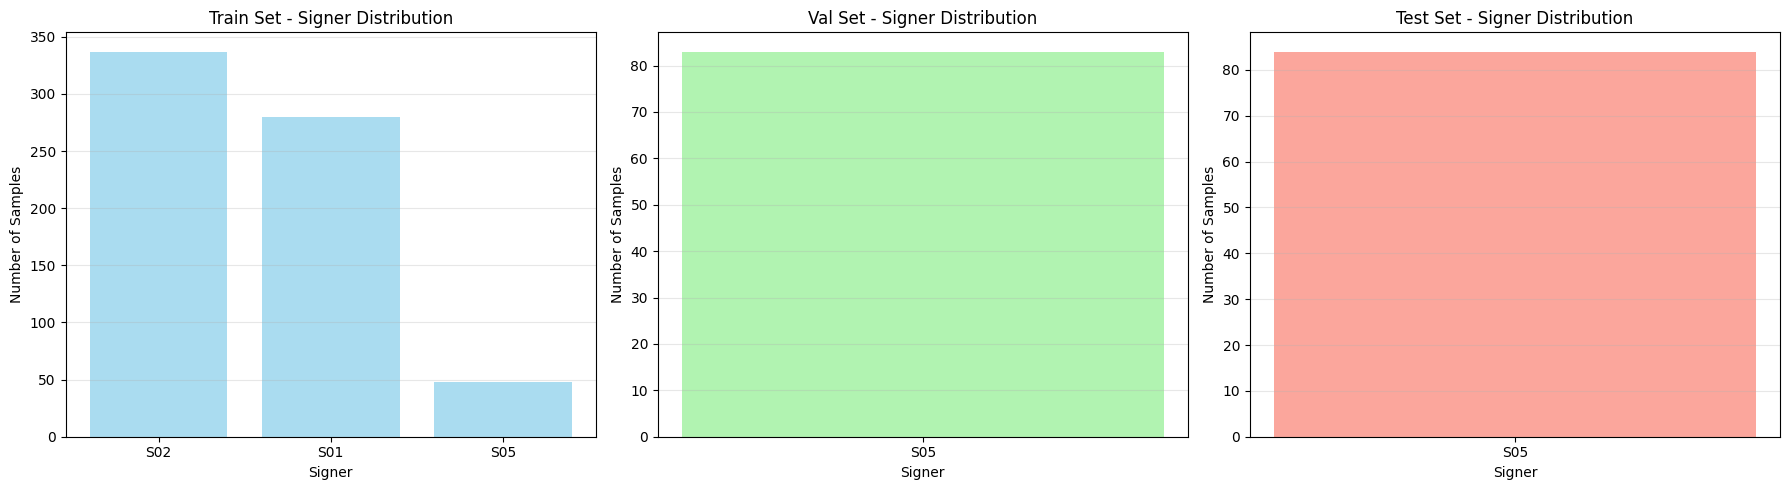

✅ Saved signer distribution plot to /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints/signer_distribution.png


In [12]:
# Visualize class distribution
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Signer distribution
for idx, (split_name, df, color) in enumerate([
    ('Train', train_df, 'skyblue'),
    ('Val', val_df, 'lightgreen'),
    ('Test', test_df, 'salmon')
]):
    signer_counts = df['signer'].value_counts()
    axes[idx].bar(signer_counts.index, signer_counts.values, color=color, alpha=0.7)
    axes[idx].set_title(f'{split_name} Set - Signer Distribution')
    axes[idx].set_xlabel('Signer')
    axes[idx].set_ylabel('Number of Samples')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'signer_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved signer distribution plot to {checkpoint_dir / 'signer_distribution.png'}")

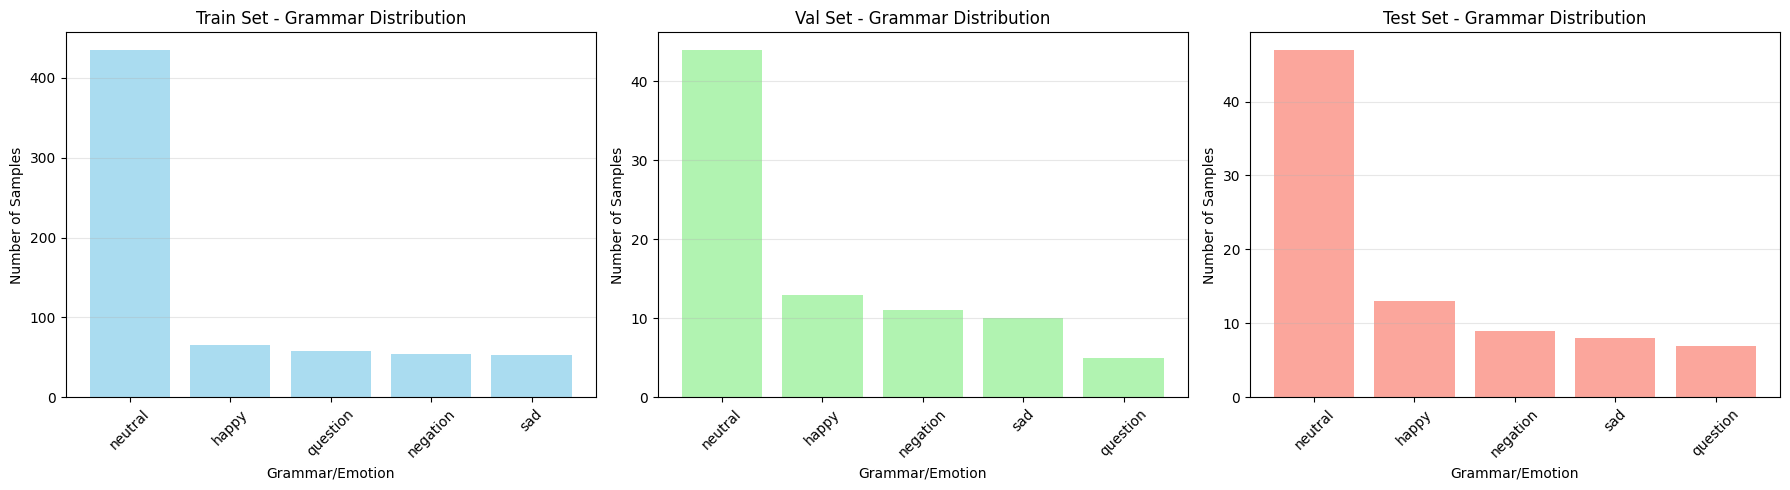

✅ Saved grammar distribution plot to /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints/grammar_distribution.png


In [13]:
# Grammar distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, df, color) in enumerate([
    ('Train', train_df, 'skyblue'),
    ('Val', val_df, 'lightgreen'),
    ('Test', test_df, 'salmon')
]):
    grammar_counts = df['grammar'].value_counts()
    axes[idx].bar(grammar_counts.index, grammar_counts.values, color=color, alpha=0.7)
    axes[idx].set_title(f'{split_name} Set - Grammar Distribution')
    axes[idx].set_xlabel('Grammar/Emotion')
    axes[idx].set_ylabel('Number of Samples')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'grammar_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved grammar distribution plot to {checkpoint_dir / 'grammar_distribution.png'}")

## Section 7: BdSLDataset Implementation

In [14]:

class BdSLDataset(Dataset):
    def __init__(self, sample_paths, word_to_label, normalized_dir,
                 max_seq_length=150, augment=False, mode='train'):
        self.sample_paths = sample_paths
        self.word_to_label = word_to_label
        self.normalized_dir = Path(normalized_dir)
        self.max_seq_length = max_seq_length
        self.augment = augment and (mode == 'train')
        self.mode = mode

        self.metadata_list = [parse_video_metadata(s) for s in sample_paths]
        self.metadata_list = [m for m in self.metadata_list if m is not None]

    def __len__(self):
        return len(self.metadata_list)

    def _npz_path(self, metadata):
        filename = f"{metadata['word']}__{metadata['signer']}__{metadata['session']}__{metadata['repetition']}__{metadata['grammar']}.npz"
        return self.normalized_dir / filename

    def _load_pose_sequence(self, metadata):
        npz_path = self._npz_path(metadata)
        if not npz_path.exists():
            raise FileNotFoundError(f"Missing .npz: {npz_path.name}")
        data = np.load(npz_path)
        if 'pose_sequence' in data:
            pose_sequence = data['pose_sequence']
        else:
            keys = list(data.keys())
            if not keys:
                raise ValueError(f"Empty .npz: {npz_path.name}")
            pose_sequence = data[keys[0]]
            if pose_sequence.ndim == 3:
                pose_sequence = pose_sequence.reshape(pose_sequence.shape[0], -1)
        return np.asarray(pose_sequence, dtype=np.float32)

    def __getitem__(self, idx):
        metadata = self.metadata_list[idx]
        label = self.word_to_label[metadata['word']]

        try:
            pose_sequence = self._load_pose_sequence(metadata)
            seq_length = min(len(pose_sequence), self.max_seq_length)
        except Exception as exc:
            print(f"⚠️  {exc}")
            pose_sequence = np.zeros((self.max_seq_length, CONFIG['input_dim']), dtype=np.float32)
            seq_length = 0

        if pose_sequence.ndim == 3:
            pose_sequence = pose_sequence.reshape(pose_sequence.shape[0], -1)

        if pose_sequence.shape[1] < CONFIG['input_dim']:
            padding = np.zeros((pose_sequence.shape[0], CONFIG['input_dim'] - pose_sequence.shape[1]), dtype=np.float32)
            pose_sequence = np.hstack([pose_sequence, padding])
        elif pose_sequence.shape[1] > CONFIG['input_dim']:
            pose_sequence = pose_sequence[:, :CONFIG['input_dim']]

        pose_sequence = pad_or_crop_centered(pose_sequence, self.max_seq_length).astype(np.float32)

        if self.augment:
            pose_sequence = self._augment_pose_sequence(pose_sequence)

        attention_mask = np.zeros(self.max_seq_length, dtype=np.float32)
        attention_mask[:seq_length] = 1

        return {
            'pose_sequence': torch.FloatTensor(pose_sequence),
            'label': torch.LongTensor([label]),
            'attention_mask': torch.FloatTensor(attention_mask),
            'seq_length': torch.LongTensor([seq_length]),
            'word': metadata['word'],
            'signer': metadata['signer'],
            'grammar': metadata['grammar']
        }

    def _augment_pose_sequence(self, sequence):
        """Apply data augmentation"""
        if np.random.random() > 0.7:
            return sequence

        augmented = sequence.copy()

        if np.random.random() < 0.3:
            scale_factor = np.random.uniform(0.8, 1.2)
            new_length = max(1, int(len(augmented) * scale_factor))
            indices = np.linspace(0, len(augmented) - 1, new_length)
            resampled = []
            for idx in indices:
                lower, upper = int(np.floor(idx)), min(int(np.ceil(idx)), len(augmented) - 1)
                weight = idx - lower
                resampled.append((1 - weight) * augmented[lower] + weight * augmented[upper])
            augmented = np.array(resampled)

            if len(augmented) < self.max_seq_length:
                padding = np.zeros((self.max_seq_length - len(augmented), CONFIG['input_dim']))
                augmented = np.vstack([augmented, padding])
            elif len(augmented) > self.max_seq_length:
                augmented = augmented[:self.max_seq_length]

        if np.random.random() < 0.4:
            noise = np.random.normal(0, 0.02, augmented.shape)
            augmented = augmented + noise

        if np.random.random() < 0.3:
            angle = np.radians(np.random.uniform(-10, 10))
            cos_a, sin_a = np.cos(angle), np.sin(angle)
            for i in range(0, CONFIG['input_dim'], 2):
                if i + 1 < CONFIG['input_dim']:
                    x = augmented[:, i] - 0.5
                    y = augmented[:, i + 1] - 0.5
                    augmented[:, i] = cos_a * x - sin_a * y + 0.5
                    augmented[:, i + 1] = sin_a * x + cos_a * y + 0.5

        return augmented

print("✅ BdSLDataset class updated")


✅ BdSLDataset class updated


## Section 8: Create DataLoaders

In [15]:

normalized_dir = Path(CONFIG['normalized_dir'])

# Create datasets
train_dataset = BdSLDataset(
    train_samples,
    word_to_label,
    normalized_dir,
    max_seq_length=CONFIG['seq_length'],
    augment=CONFIG['augmentation'],
    mode='train'
)

val_dataset = BdSLDataset(
    val_samples,
    word_to_label,
    normalized_dir,
    max_seq_length=CONFIG['seq_length'],
    augment=False,
    mode='val'
)

test_dataset = BdSLDataset(
    test_samples,
    word_to_label,
    normalized_dir,
    max_seq_length=CONFIG['seq_length'],
    augment=False,
    mode='test'
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'] * 2,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'] * 2,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ DataLoaders created:")
print(f"   Train: {len(train_loader)} batches")
print(f"   Val: {len(val_loader)} batches")
print(f"   Test: {len(test_loader)} batches")
print(f"   Total train samples: {len(train_dataset)}")
print(f"   Total val samples: {len(val_dataset)}")
print(f"   Total test samples: {len(test_dataset)}")


✅ DataLoaders created:
   Train: 42 batches
   Val: 3 batches
   Test: 3 batches
   Total train samples: 665
   Total val samples: 83
   Total test samples: 84


In [16]:
# Test data loading
sample_batch = next(iter(train_loader))
print(f"✅ Sample batch loaded successfully")
print(f"   pose_sequence shape: {sample_batch['pose_sequence'].shape}")
print(f"   label shape: {sample_batch['label'].shape}")
print(f"   attention_mask shape: {sample_batch['attention_mask'].shape}")
print(f"   seq_length shape: {sample_batch['seq_length'].shape}")
print(f"\n   Sample labels: {sample_batch['label'][:5].flatten().tolist()}")
print(f"   Sample words: {[sample_batch['word'][i] for i in range(5)]}")

✅ Sample batch loaded successfully
   pose_sequence shape: torch.Size([16, 150, 108])
   label shape: torch.Size([16, 1])
   attention_mask shape: torch.Size([16, 150])
   seq_length shape: torch.Size([16, 1])

   Sample labels: [5, 67, 63, 51, 4]
   Sample words: ['ইতিহাস', 'সুন্দর', 'সঠিক', 'ভুল', 'আমি']


## Section 9: Positional Encoding

In [17]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=150):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length + 1, d_model)
        position = torch.arange(0, max_seq_length + 1, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """Add positional encoding to input"""
        # x shape: (batch_size, seq_len, d_model)
        # pe shape: (1, max_seq_len + 1, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

print("✅ PositionalEncoding class implemented")

✅ PositionalEncoding class implemented


## Section 10: ProductionSPOTER Model

In [18]:
class ProductionSPOTER(nn.Module):
    def __init__(self, input_dim=108, d_model=108, num_heads=9,
                 num_encoder_layers=8, d_ff=512, num_classes=72,
                 max_seq_length=150, dropout=0.15):
        super(ProductionSPOTER, self).__init__()
        
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        
        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5)
        )
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        # Class token
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.1)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(d_model // 2, num_classes)
        )
    
    def forward(self, x, attention_mask=None):
        """
        Forward pass
        Args:
            x: (batch_size, seq_len, input_dim)
            attention_mask: (batch_size, seq_len) - 1 for real, 0 for padding
        Returns:
            logits: (batch_size, num_classes)
        """
        batch_size, seq_len, _ = x.shape
        
        # Project input
        x = self.input_projection(x)
        
        # Add class token
        class_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat([class_tokens, x], dim=1)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Prepare attention mask for transformer
        if attention_mask is not None:
            # Add mask for class token (always attend)
            class_mask = torch.ones(batch_size, 1, device=attention_mask.device)
            full_mask = torch.cat([class_mask, attention_mask], dim=1)
            # Convert to transformer format (True = masked, False = attend)
            transformer_mask = (full_mask == 0)
        else:
            transformer_mask = None
        
        # Transformer encoder
        encoded = self.transformer_encoder(x, src_key_padding_mask=transformer_mask)
        
        # Use class token for classification
        class_representation = encoded[:, 0]
        
        # Classification
        logits = self.classifier(class_representation)
        
        return logits

print("✅ ProductionSPOTER model implemented")

✅ ProductionSPOTER model implemented


## Section 11: Initialize Model

In [19]:
model = ProductionSPOTER(
    input_dim=CONFIG['input_dim'],
    d_model=CONFIG['d_model'],
    num_heads=CONFIG['num_heads'],
    num_encoder_layers=CONFIG['num_encoder_layers'],
    d_ff=CONFIG['d_ff'],
    num_classes=CONFIG['num_classes'],
    max_seq_length=CONFIG['seq_length'],
    dropout=CONFIG['dropout']
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model initialized successfully")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / 1024**2:.2f} MB (float32)")

✅ Model initialized successfully
   Total parameters: 1,303,786
   Trainable parameters: 1,303,786
   Model size: 4.97 MB (float32)


In [20]:
# Test forward pass
test_batch_size = 4
test_input = torch.randn(test_batch_size, CONFIG['seq_length'], CONFIG['input_dim']).to(device)
test_mask = torch.ones(test_batch_size, CONFIG['seq_length']).to(device)

with torch.no_grad():
    logits = model(test_input, test_mask)

print(f"✅ Forward pass test successful")
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {logits.shape}")
print(f"   Expected output shape: ({test_batch_size}, {CONFIG['num_classes']})")

✅ Forward pass test successful
   Input shape: torch.Size([4, 150, 108])
   Output shape: torch.Size([4, 72])
   Expected output shape: (4, 72)


## Section 12: WandB Setup

In [21]:
import wandb

# WandB initialization
wandb.init(
    project="bangla-sign-language-recognition",
    entity=None,  # Auto-detect
    config=CONFIG,
    name=f"BdSL_SPOTER_{len(train_samples)}samples_{CONFIG['epochs']}epochs_{CONFIG['batch_size']}batch"
)

# Watch model for gradients and parameters
wandb.watch(model, log_freq=100)

print("✅ WandB initialized")
print(f"   Project: bangla-sign-language-recognition")
print(f"   Run name: BdSL_SPOTER_{len(train_samples)}samples_{CONFIG['epochs']}epochs_{CONFIG['batch_size']}batch")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/raco/.netrc.
wandb: Currently logged in as: aber-islam-dev (aber-islam-dev-jvai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ WandB initialized
   Project: bangla-sign-language-recognition
   Run name: BdSL_SPOTER_665samples_100epochs_16batch


## Section 13: Training Utilities

In [22]:
from torch.optim.lr_scheduler import OneCycleLR

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    betas=(0.9, 0.95),
    eps=1e-8
)

# Learning rate scheduler
total_steps = len(train_loader) * CONFIG['epochs']
scheduler = OneCycleLR(
    optimizer,
    max_lr=CONFIG['learning_rate'] * 3,  # Peak LR = 3x base
    epochs=CONFIG['epochs'],
    steps_per_epoch=len(train_loader),
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos'
)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

print("✅ Training utilities configured")
print(f"   Optimizer: AdamW (lr={CONFIG['learning_rate']}, weight_decay={CONFIG['weight_decay']})")
print(f"   Scheduler: OneCycleLR (max_lr={CONFIG['learning_rate'] * 3:.6f})")
print(f"   Loss: CrossEntropy (label_smoothing={CONFIG['label_smoothing']})")

✅ Training utilities configured
   Optimizer: AdamW (lr=0.0003, weight_decay=0.05)
   Scheduler: OneCycleLR (max_lr=0.000900)
   Loss: CrossEntropy (label_smoothing=0.1)


In [23]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        pose_sequences = batch['pose_sequence'].to(device)
        labels = batch['label'].squeeze().to(device)
        attention_masks = batch['attention_mask'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(pose_sequences, attention_masks)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        scheduler.step()
        
        # Metrics
        total_loss += loss.item() * len(labels)
        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += len(labels)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            pose_sequences = batch['pose_sequence'].to(device)
            labels = batch['label'].squeeze().to(device)
            attention_masks = batch['attention_mask'].to(device)
            
            # Forward pass
            logits = model(pose_sequences, attention_masks)
            loss = criterion(logits, labels)
            
            # Metrics
            total_loss += loss.item() * len(labels)
            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

print("✅ Training/validation functions defined")

✅ Training/validation functions defined


## Section 14: Training Loop (50 Epochs)

In [24]:
## Section 14: Training Loop (50 Epochs)

# Initialize training state
best_val_acc = 0.0
no_improve_count = 0
patience = CONFIG['early_stopping_patience']

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

# Track if any checkpoint was saved
any_checkpoint_saved = False

print(f"🚀 Starting training for {CONFIG['epochs']} epochs")
print(f"   Early stopping patience: {patience}")
print(f"   Primary metric: {CONFIG['primary_metric']}")
print(f"   Checkpoint directory: {checkpoint_dir}")

for epoch in range(CONFIG['epochs']):
    print(f"\n" + "="*70)
    print(f"Epoch {epoch + 1}/{CONFIG['epochs']}")
    print(f"="*70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]
    
    # Log to WandB
    wandb.log({
        'epoch': epoch + 1,
        'train/loss': train_loss,
        'train/accuracy': train_acc,
        'val/loss': val_loss,
        'val/accuracy': val_acc,
        'learning_rate': current_lr
    })
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    
    # Print summary - FIXED: removed extra braces
    print(f"\n📊 Epoch {epoch + 1} Summary:")
    print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   LR: {current_lr:.6f}")
    
    # Ensure checkpoint directory exists (safety check)
    checkpoint_dir = Path(CONFIG['checkpoint_dir'])
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_count = 0
        
        # Save checkpoint - FIXED: removed extra parenthesis
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_accuracy': val_acc,
            'val_loss': val_loss,
            'config': CONFIG
        }, checkpoint_dir / "best_model.pth")
        
        any_checkpoint_saved = True
        print(f"   ✨ New best model saved! Val Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")
        wandb.save(str(checkpoint_dir / "best_model.pth"))
        
    else:
        no_improve_count += 1
        print(f"   No improvement for {no_improve_count} epochs")
        
        # Fallback: Save checkpoint every 20 epochs if none saved yet
        if not any_checkpoint_saved and (epoch + 1) % 20 == 0:
            print(f"   ⚠️  No improvement yet, saving intermediate checkpoint...")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_accuracy': val_acc,
                'val_loss': val_loss,
                'config': CONFIG
            }, checkpoint_dir / "checkpoint_epoch_fallback.pth")  # FIXED: removed extra parenthesis
            print(f"   💾 Fallback checkpoint saved at epoch {epoch + 1}")
            any_checkpoint_saved = True
    
    # Early stopping check
    if no_improve_count >= patience:
        print(f"\n⏹️  Early stopping triggered after {patience} epochs without improvement")
        print(f"   Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
        break

print(f"\n✅ Training complete!")
print(f"   Total epochs trained: {epoch + 1}")
print(f"   Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")


🚀 Starting training for 100 epochs
   Early stopping patience: 25
   Primary metric: top-1_accuracy
   Checkpoint directory: /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints

Epoch 1/100


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.



📊 Epoch 1 Summary:
   Train - Loss: 4.2780, Acc: 0.0180 (1.80%)
   Val   - Loss: 4.3033, Acc: 0.0241 (2.41%)
   LR: 0.000057
   ✨ New best model saved! Val Acc: 0.0241 (2.41%)

Epoch 2/100



📊 Epoch 2 Summary:
   Train - Loss: 4.2694, Acc: 0.0165 (1.65%)
   Val   - Loss: 4.3025, Acc: 0.0000 (0.00%)
   LR: 0.000119
   No improvement for 1 epochs

Epoch 3/100



📊 Epoch 3 Summary:
   Train - Loss: 4.2618, Acc: 0.0241 (2.41%)
   Val   - Loss: 4.2998, Acc: 0.0000 (0.00%)
   LR: 0.000215
   No improvement for 2 epochs

Epoch 4/100



📊 Epoch 4 Summary:
   Train - Loss: 4.2473, Acc: 0.0226 (2.26%)
   Val   - Loss: 4.3103, Acc: 0.0000 (0.00%)
   LR: 0.000336
   No improvement for 3 epochs

Epoch 5/100



📊 Epoch 5 Summary:
   Train - Loss: 4.2221, Acc: 0.0150 (1.50%)
   Val   - Loss: 4.2797, Acc: 0.0000 (0.00%)
   LR: 0.000470
   No improvement for 4 epochs

Epoch 6/100



📊 Epoch 6 Summary:
   Train - Loss: 4.1899, Acc: 0.0195 (1.95%)
   Val   - Loss: 4.3610, Acc: 0.0000 (0.00%)
   LR: 0.000603
   No improvement for 5 epochs

Epoch 7/100



📊 Epoch 7 Summary:
   Train - Loss: 4.1971, Acc: 0.0180 (1.80%)
   Val   - Loss: 4.3193, Acc: 0.0000 (0.00%)
   LR: 0.000724
   No improvement for 6 epochs

Epoch 8/100



📊 Epoch 8 Summary:
   Train - Loss: 4.1882, Acc: 0.0271 (2.71%)
   Val   - Loss: 4.3535, Acc: 0.0000 (0.00%)
   LR: 0.000819
   No improvement for 7 epochs

Epoch 9/100



📊 Epoch 9 Summary:
   Train - Loss: 4.2087, Acc: 0.0226 (2.26%)
   Val   - Loss: 4.3651, Acc: 0.0000 (0.00%)
   LR: 0.000880
   No improvement for 8 epochs

Epoch 10/100



📊 Epoch 10 Summary:
   Train - Loss: 4.1795, Acc: 0.0271 (2.71%)
   Val   - Loss: 4.3491, Acc: 0.0000 (0.00%)
   LR: 0.000900
   No improvement for 9 epochs

Epoch 11/100



📊 Epoch 11 Summary:
   Train - Loss: 4.1751, Acc: 0.0301 (3.01%)
   Val   - Loss: 4.3341, Acc: 0.0000 (0.00%)
   LR: 0.000900
   No improvement for 10 epochs

Epoch 12/100



📊 Epoch 12 Summary:
   Train - Loss: 4.1794, Acc: 0.0090 (0.90%)
   Val   - Loss: 4.3593, Acc: 0.0000 (0.00%)
   LR: 0.000899
   No improvement for 11 epochs

Epoch 13/100



📊 Epoch 13 Summary:
   Train - Loss: 4.1721, Acc: 0.0211 (2.11%)
   Val   - Loss: 4.3931, Acc: 0.0000 (0.00%)
   LR: 0.000897
   No improvement for 12 epochs

Epoch 14/100



📊 Epoch 14 Summary:
   Train - Loss: 4.1711, Acc: 0.0135 (1.35%)
   Val   - Loss: 4.3521, Acc: 0.0000 (0.00%)
   LR: 0.000896
   No improvement for 13 epochs

Epoch 15/100



📊 Epoch 15 Summary:
   Train - Loss: 4.1668, Acc: 0.0271 (2.71%)
   Val   - Loss: 4.3999, Acc: 0.0000 (0.00%)
   LR: 0.000893
   No improvement for 14 epochs

Epoch 16/100



📊 Epoch 16 Summary:
   Train - Loss: 4.1657, Acc: 0.0226 (2.26%)
   Val   - Loss: 4.4015, Acc: 0.0000 (0.00%)
   LR: 0.000890
   No improvement for 15 epochs

Epoch 17/100



📊 Epoch 17 Summary:
   Train - Loss: 4.1635, Acc: 0.0226 (2.26%)
   Val   - Loss: 4.3636, Acc: 0.0000 (0.00%)
   LR: 0.000887
   No improvement for 16 epochs

Epoch 18/100



📊 Epoch 18 Summary:
   Train - Loss: 4.1672, Acc: 0.0241 (2.41%)
   Val   - Loss: 4.3842, Acc: 0.0000 (0.00%)
   LR: 0.000882
   No improvement for 17 epochs

Epoch 19/100



📊 Epoch 19 Summary:
   Train - Loss: 4.1650, Acc: 0.0256 (2.56%)
   Val   - Loss: 4.3869, Acc: 0.0000 (0.00%)
   LR: 0.000878
   No improvement for 18 epochs

Epoch 20/100



📊 Epoch 20 Summary:
   Train - Loss: 4.1650, Acc: 0.0211 (2.11%)
   Val   - Loss: 4.3582, Acc: 0.0000 (0.00%)
   LR: 0.000873
   No improvement for 19 epochs

Epoch 21/100



📊 Epoch 21 Summary:
   Train - Loss: 4.1640, Acc: 0.0271 (2.71%)
   Val   - Loss: 4.3761, Acc: 0.0000 (0.00%)
   LR: 0.000867
   No improvement for 20 epochs

Epoch 22/100



📊 Epoch 22 Summary:
   Train - Loss: 4.1648, Acc: 0.0256 (2.56%)
   Val   - Loss: 4.3684, Acc: 0.0000 (0.00%)
   LR: 0.000861
   No improvement for 21 epochs

Epoch 23/100



📊 Epoch 23 Summary:
   Train - Loss: 4.1642, Acc: 0.0165 (1.65%)
   Val   - Loss: 4.3831, Acc: 0.0000 (0.00%)
   LR: 0.000854
   No improvement for 22 epochs

Epoch 24/100



📊 Epoch 24 Summary:
   Train - Loss: 4.1616, Acc: 0.0271 (2.71%)
   Val   - Loss: 4.4081, Acc: 0.0000 (0.00%)
   LR: 0.000847
   No improvement for 23 epochs

Epoch 25/100



📊 Epoch 25 Summary:
   Train - Loss: 4.1594, Acc: 0.0241 (2.41%)
   Val   - Loss: 4.3940, Acc: 0.0000 (0.00%)
   LR: 0.000840
   No improvement for 24 epochs

Epoch 26/100



📊 Epoch 26 Summary:
   Train - Loss: 4.1628, Acc: 0.0271 (2.71%)
   Val   - Loss: 4.3658, Acc: 0.0000 (0.00%)
   LR: 0.000831
   No improvement for 25 epochs

⏹️  Early stopping triggered after 25 epochs without improvement
   Best validation accuracy: 0.0241 (2.41%)

✅ Training complete!
   Total epochs trained: 26
   Best validation accuracy: 0.0241 (2.41%)


## Section 15: Load Best Model

In [25]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_dir / 'best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
print(f"   Validation accuracy: {checkpoint['val_accuracy']:.4f} ({checkpoint['val_accuracy']*100:.2f}%)")
print(f"   Validation loss: {checkpoint['val_loss']:.4f}")

✅ Loaded best model from epoch 1
   Validation accuracy: 0.0241 (2.41%)
   Validation loss: 4.3033


In [26]:
# Check if checkpoint exists before loading
checkpoint_path = checkpoint_dir / 'best_model.pth'

if not checkpoint_path.exists():
    print(f"\n{'='*70}")
    print(f"❌ ERROR: Checkpoint Not Found")
    print(f"{'='*70}")
    print()
    print(f"Expected checkpoint: {checkpoint_path}")
    print(f"Current checkpoint directory: {checkpoint_dir}")
    print()
    print(f"Current files in checkpoint directory:")
    if checkpoint_dir.exists():
        for file in sorted(checkpoint_dir.glob('*')):
            size_kb = file.stat().st_size / 1024
            print(f"  - {file.name} ({size_kb:.1f} KB)")
    else:
        print(f"  (Directory does not exist)")
    print()
    print(f"💡 SOLUTION: Run Section 14 (Training Loop) first")
    print()
    print(f"To train the model:")
    print(f"  1. Navigate to Section 14 (Training Loop)")
    print(f"  2. Execute the training code cell")
    print(f"  3. Wait for training to complete (~30-60 minutes on GPU)")
    print(f"  4. Return to this section")
    print()
    print(f"⚠️  Halting execution to prevent meaningless evaluation")
    print(f"{'='*70}")
    raise SystemExit("Training required before evaluation")

# Attempt to load checkpoint with comprehensive error handling
try:
    print(f"📥 Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    
    # Validate checkpoint structure
    required_keys = ['epoch', 'model_state_dict', 'optimizer_state_dict', 
                    'scheduler_state_dict', 'val_accuracy', 'val_loss', 'config']
    missing_keys = [key for key in required_keys if key not in checkpoint]
    if missing_keys:
        print(f"❌ ERROR: Invalid checkpoint structure")
        print(f"   Missing keys: {missing_keys}")
        raise ValueError(f"Checkpoint missing required keys: {missing_keys}")
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    # Display checkpoint info
    print(f"✅ Checkpoint loaded successfully!")
    print(f"   Epoch: {checkpoint['epoch']}")
    print(f"   Validation accuracy: {checkpoint['val_accuracy']:.4f} ({checkpoint['val_accuracy']*100:.2f}%)")
    print(f"   Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"   Training config keys: {list(checkpoint['config'].keys())}")

except FileNotFoundError as e:
    print(f"❌ ERROR: Checkpoint file not found")
    print(f"   {e}")
    print(f"   Path: {checkpoint_path}")
    raise SystemExit("Checkpoint file missing")

except RuntimeError as e:
    # Catches CUDA/CPU device issues
    if 'CUDA' in str(e) or 'device' in str(e).lower():
        print(f"❌ ERROR: Device mismatch")
        print(f"   {e}")
        print(f"   Model device: {next(model.parameters()).device}")
        print(f"   Expected device: {device}")
        print(f"   💡 TIP: Ensure GPU is available or change device to 'cpu'")
        raise SystemExit("Device mismatch")
    else:
        raise

except ValueError as e:
    # Catches invalid checkpoint structure
    print(f"❌ ERROR: Invalid checkpoint format")
    print(f"   {e}")
    raise SystemExit("Invalid checkpoint")

except Exception as e:
    # Catch-all for unexpected errors
    print(f"❌ ERROR: Failed to load checkpoint")
    print(f"   Error type: {type(e).__name__}")
    print(f"   Message: {e}")
    print(f"   💡 TIP: Check if checkpoint is from same model version")
    raise SystemExit(f"Checkpoint loading failed: {e}")

📥 Loading checkpoint from: /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints/best_model.pth
✅ Checkpoint loaded successfully!
   Epoch: 1
   Validation accuracy: 0.0241 (2.41%)
   Validation loss: 4.3033
   Training config keys: ['total_samples', 'num_classes', 'train_val_test', 'input_dim', 'seq_length', 'num_encoder_layers', 'num_heads', 'd_model', 'd_ff', 'epochs', 'batch_size', 'learning_rate', 'weight_decay', 'label_smoothing', 'dropout', 'early_stopping_patience', 'primary_metric', 'augmentation', 'max_frames', 'mediapipe_complexity', 'base_dir', 'processed_dir', 'normalized_dir', 'checkpoint_dir']


## Section 16: Test Evaluation

In [27]:
# Model Verification Helper
print(f"\n{'='*70}")
print(f"🔍 Model Verification")
print(f"{'='*70}")

if 'checkpoint' in locals() and checkpoint is not None:
    # Model is loaded - verify state
    print(f"✅ Checkpoint loaded: Yes")
    num_params = sum(p.numel() for p in model.parameters())
    print(f"   Model parameters: {num_params:,}")
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Model trainable parameters: {trainable_params:,}")
    model_device = next(model.parameters()).device
    print(f"   Model device: {model_device}")
    
    # Check if model is in evaluation mode
    if not model.training:
        print(f"   Model mode: eval ✅")
    else:
        print(f"   Model mode: train ⚠️")
        model.eval()
        print(f"   → Changed to eval mode ✅")
    
    print(f"\n🧪 Testing forward pass...")
    try:
        with torch.no_grad():
            test_input = torch.randn(1, CONFIG['seq_length'], CONFIG['input_dim']).to(device)
            output = model(test_input)
        print(f"✅ Forward pass successful")
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   Output range: [{output.min():.4f}, {output.max():.4f}]")
        print(f"   Output type: {output.dtype}")
        print(f"\n{'='*70}")
        print(f"✅ Model verification complete - ready for evaluation!")
        print(f"{'='*70}")
    except Exception as e:
        print(f"❌ Forward pass failed: {e}")
        print(f"   💡 Model may be corrupted or architecture mismatch")
else:
    print(f"❌ Checkpoint loaded: No")
    print(f"   ⚠️  Evaluation metrics will be meaningless")
    print(f"{'='*70}")



🔍 Model Verification
✅ Checkpoint loaded: Yes
   Model parameters: 1,303,786
   Model trainable parameters: 1,303,786
   Model device: cuda:0
   Model mode: eval ✅

🧪 Testing forward pass...
✅ Forward pass successful
   Input shape: torch.Size([1, 150, 108])
   Output shape: torch.Size([1, 72])
   Output range: [-0.1997, 0.2292]
   Output type: torch.float32

✅ Model verification complete - ready for evaluation!


## Section 16: Test Evaluation

In [28]:
# Evaluate on test set
model.eval()
all_predictions = []
all_labels = []
all_words = []
all_signers = []
all_probs = []

print("🔍 Evaluating on test set...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        pose_sequences = batch['pose_sequence'].to(device)
        labels = batch['label'].squeeze().to(device)
        words = batch['word']
        signers = batch['signer']
        
        # Forward pass
        logits = model(pose_sequences)
        probs = F.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)
        
        # Collect results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_words.extend(words)
        all_signers.extend(signers)
        all_probs.extend(probs.cpu().numpy())

print(f"✅ Test evaluation complete")
print(f"   Total test samples: {len(all_predictions)}")

🔍 Evaluating on test set...


Testing: 100%|████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.96it/s]

✅ Test evaluation complete
   Total test samples: 84


In [29]:
# Calculate overall metrics
test_accuracy = accuracy_score(all_labels, all_predictions)
test_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
test_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
test_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

print(f"\n📊 Test Results:")
print(f"{'='*50}")
print(f"Top-1 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision (macro): {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall (macro): {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score (macro): {test_f1:.4f} ({test_f1*100:.2f}%)")

# Log to WandB
wandb.log({
    'test/accuracy': test_accuracy,
    'test/precision': test_precision,
    'test/recall': test_recall,
    'test/f1_score': test_f1
})

print(f"\n✅ Metrics logged to WandB")


📊 Test Results:
Top-1 Accuracy: 0.0000 (0.00%)
Precision (macro): 0.0000 (0.00%)
Recall (macro): 0.0000 (0.00%)
F1-Score (macro): 0.0000 (0.00%)

✅ Metrics logged to WandB


## Section 17: Per-Signer Analysis

In [30]:
# Calculate accuracy per signer
signer_accuracies = {}
signer_counts = {}

print(f"\n📊 Per-Signer Analysis:")
print(f"{'='*50}")

for signer in ['S01', 'S02', 'S05']:
    signer_indices = [i for i, s in enumerate(all_signers) if s == signer]
    if signer_indices:
        signer_labels = [all_labels[i] for i in signer_indices]
        signer_preds = [all_predictions[i] for i in signer_indices]
        acc = accuracy_score(signer_labels, signer_preds)
        signer_accuracies[signer] = acc
        signer_counts[signer] = len(signer_indices)
        print(f"{signer}: {acc:.4f} ({acc*100:.2f}%) - {len(signer_indices)} samples")

# Log to WandB
wandb.log({'test/signer_accuracies': signer_accuracies})

print(f"\n✅ Per-signer accuracies logged to WandB")


📊 Per-Signer Analysis:
S05: 0.0000 (0.00%) - 84 samples

✅ Per-signer accuracies logged to WandB


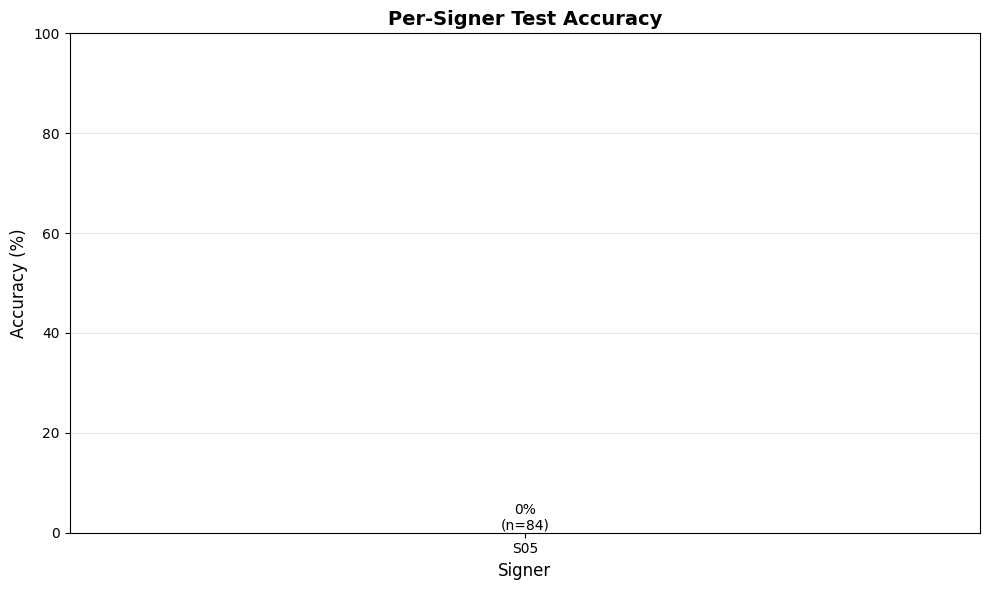

✅ Per-signer accuracy plot saved and logged to WandB


In [31]:
# Visualize per-signer accuracy
fig, ax = plt.subplots(figsize=(10, 6))
signers = list(signer_accuracies.keys())
accuracies = [signer_accuracies[s] * 100 for s in signers]
counts = [signer_counts[s] for s in signers]

bars = ax.bar(signers, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8)
ax.set_xlabel('Signer', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Signer Test Accuracy', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Add sample count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}%\n(n={count})',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'per_signer_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'test/per_signer_accuracy_plot': wandb.Image(str(checkpoint_dir / 'per_signer_accuracy.png'))})

print(f"✅ Per-signer accuracy plot saved and logged to WandB")

## Section 18: Confusion Matrix & Visualization

In [32]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Normalize by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(f"✅ Confusion matrix created")
print(f"   Shape: {cm.shape}")
print(f"   Total samples: {cm.sum()}")

✅ Confusion matrix created
   Shape: (26, 26)
   Total samples: 84


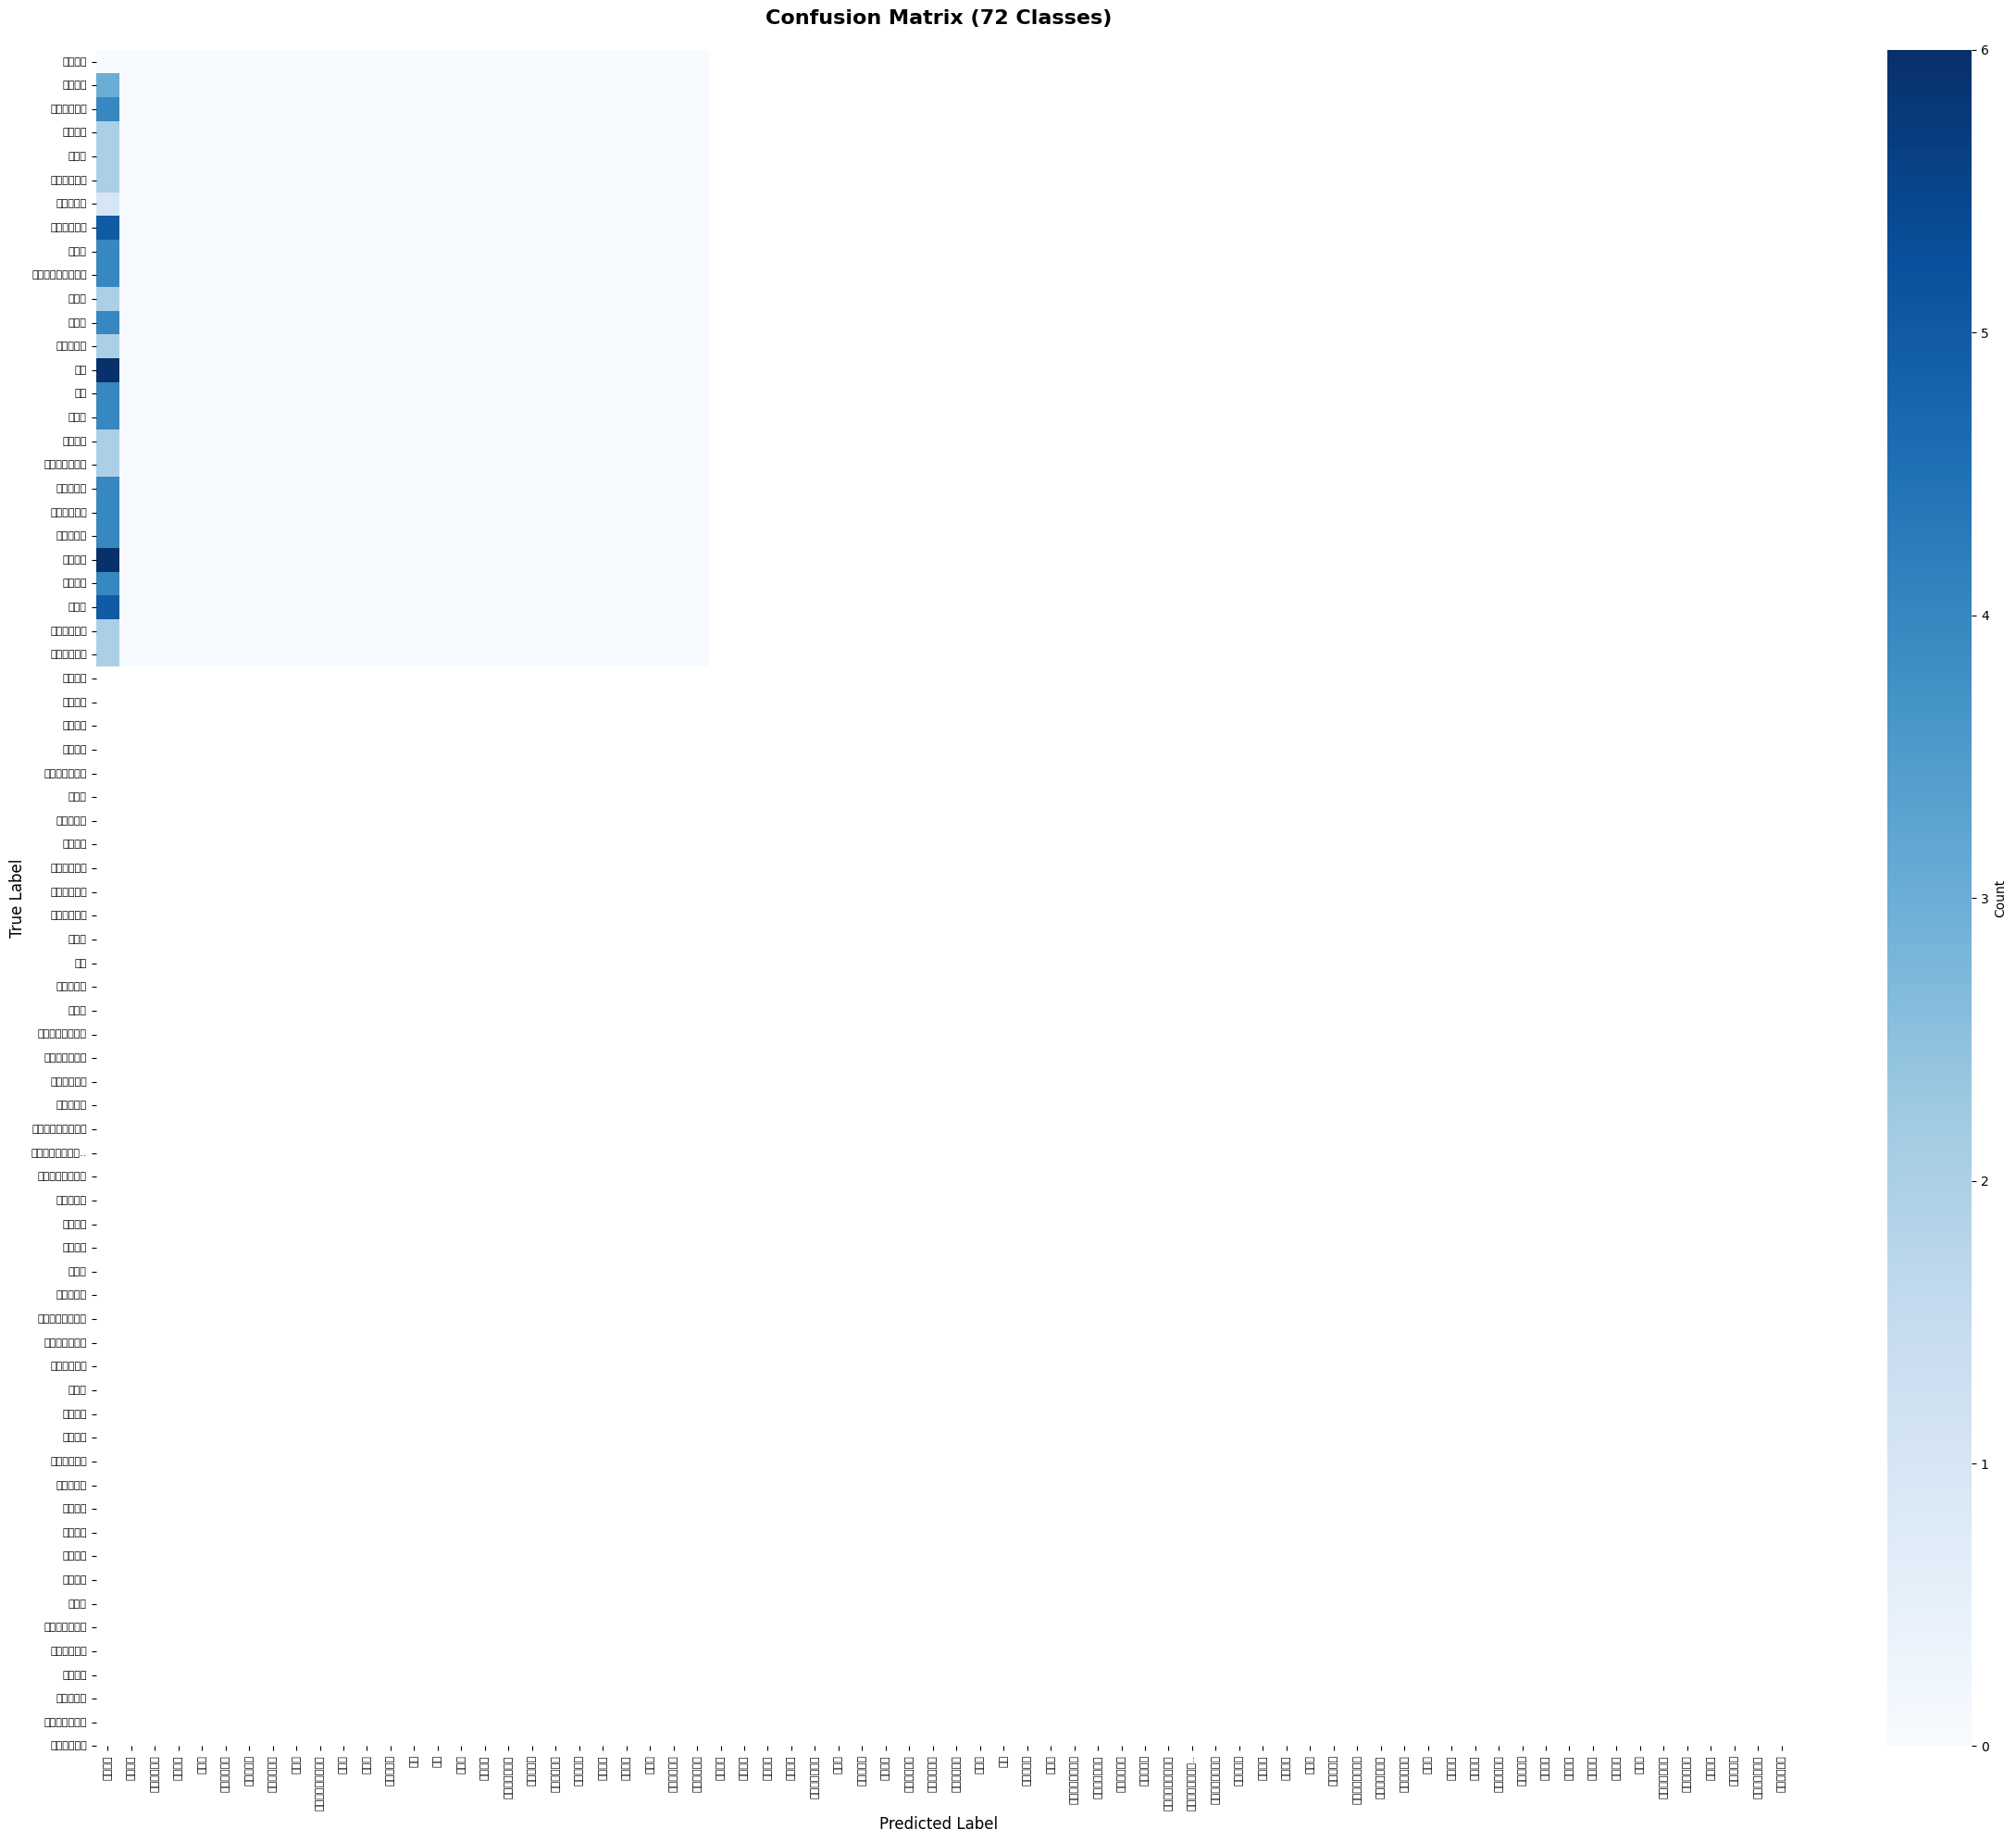

✅ Confusion matrix saved and logged to WandB


In [33]:
# Plot confusion matrix (full 72x72)
plt.style.use('default')
fig, ax = plt.subplots(figsize=(24, 20))

# Create heatmap with short labels
short_labels = [label_to_word[i][:8] + '..' if len(label_to_word[i]) > 10 else label_to_word[i] 
               for i in range(72)]

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=short_labels,
            yticklabels=short_labels,
            ax=ax, cbar_kws={'label': 'Count'})

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix (72 Classes)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'test/confusion_matrix': wandb.Image(str(checkpoint_dir / 'confusion_matrix.png'))})

print(f"✅ Confusion matrix saved and logged to WandB")

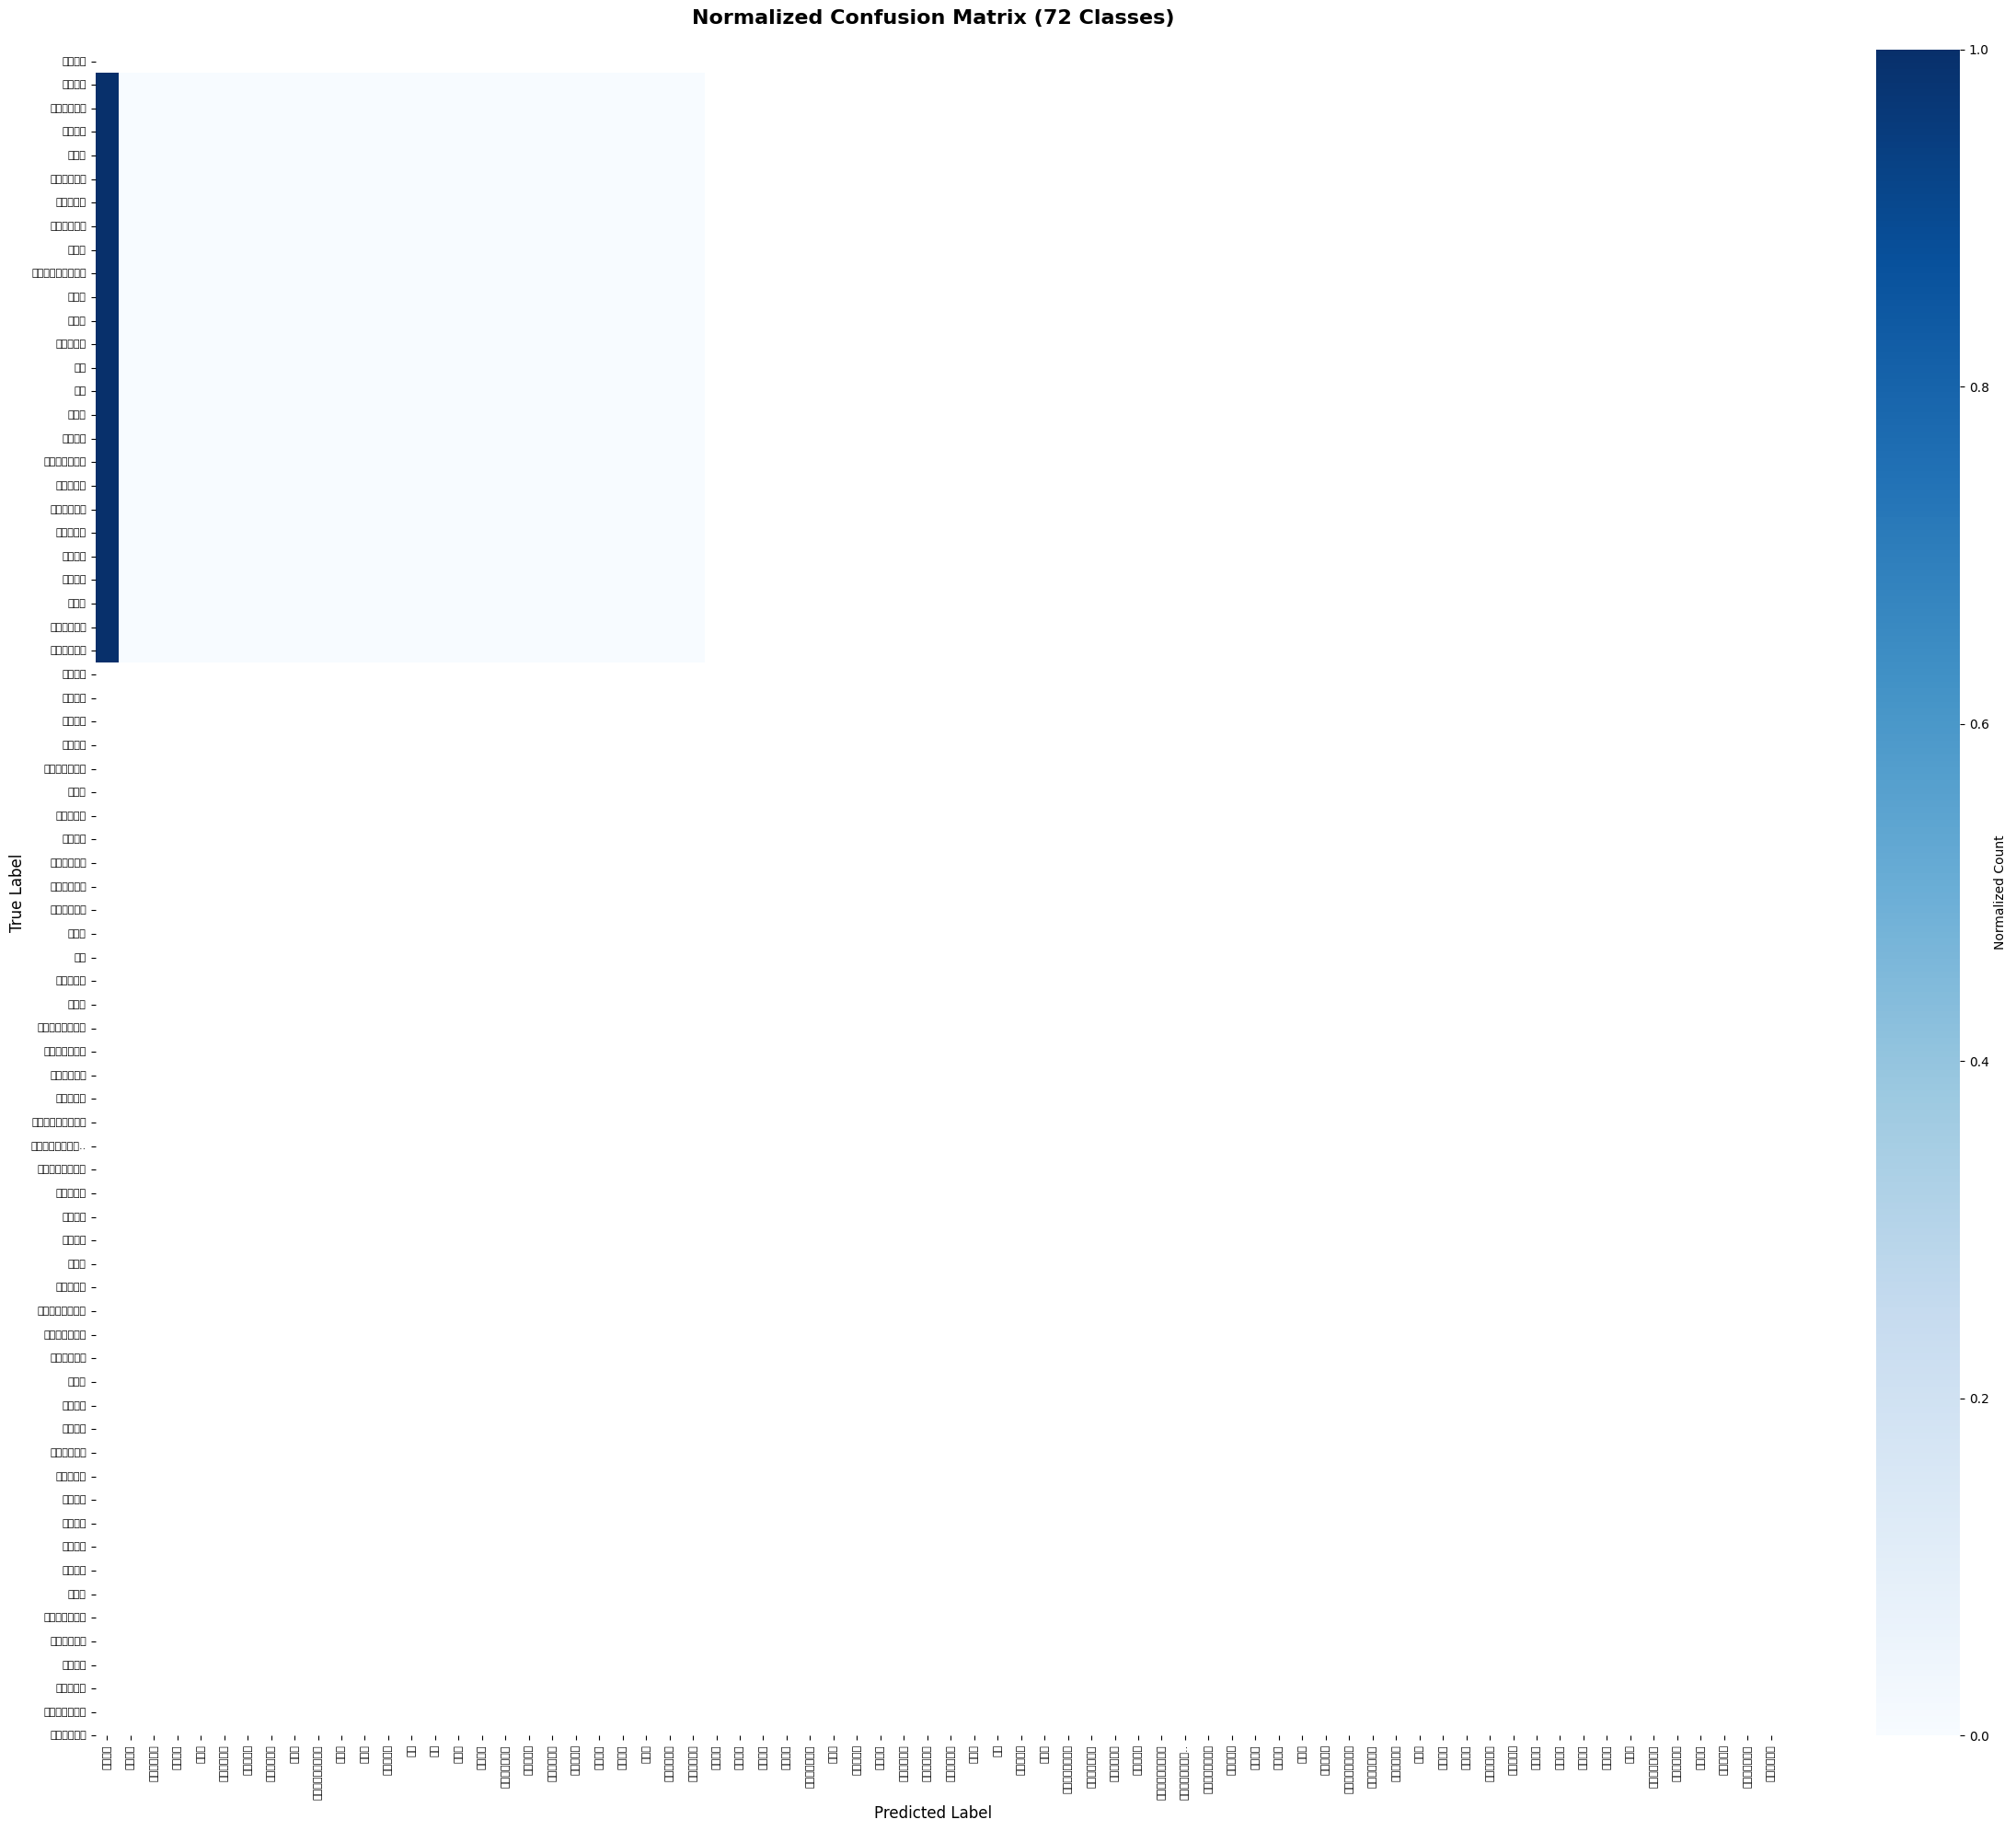

✅ Normalized confusion matrix saved and logged to WandB


In [34]:
# Plot normalized confusion matrix
fig, ax = plt.subplots(figsize=(24, 20))

sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', 
            xticklabels=short_labels,
            yticklabels=short_labels,
            ax=ax, cbar_kws={'label': 'Normalized Count'},
            vmin=0, vmax=1)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Normalized Confusion Matrix (72 Classes)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'test/confusion_matrix_normalized': wandb.Image(str(checkpoint_dir / 'confusion_matrix_normalized.png'))})

print(f"✅ Normalized confusion matrix saved and logged to WandB")

## Section 19: Training Curves

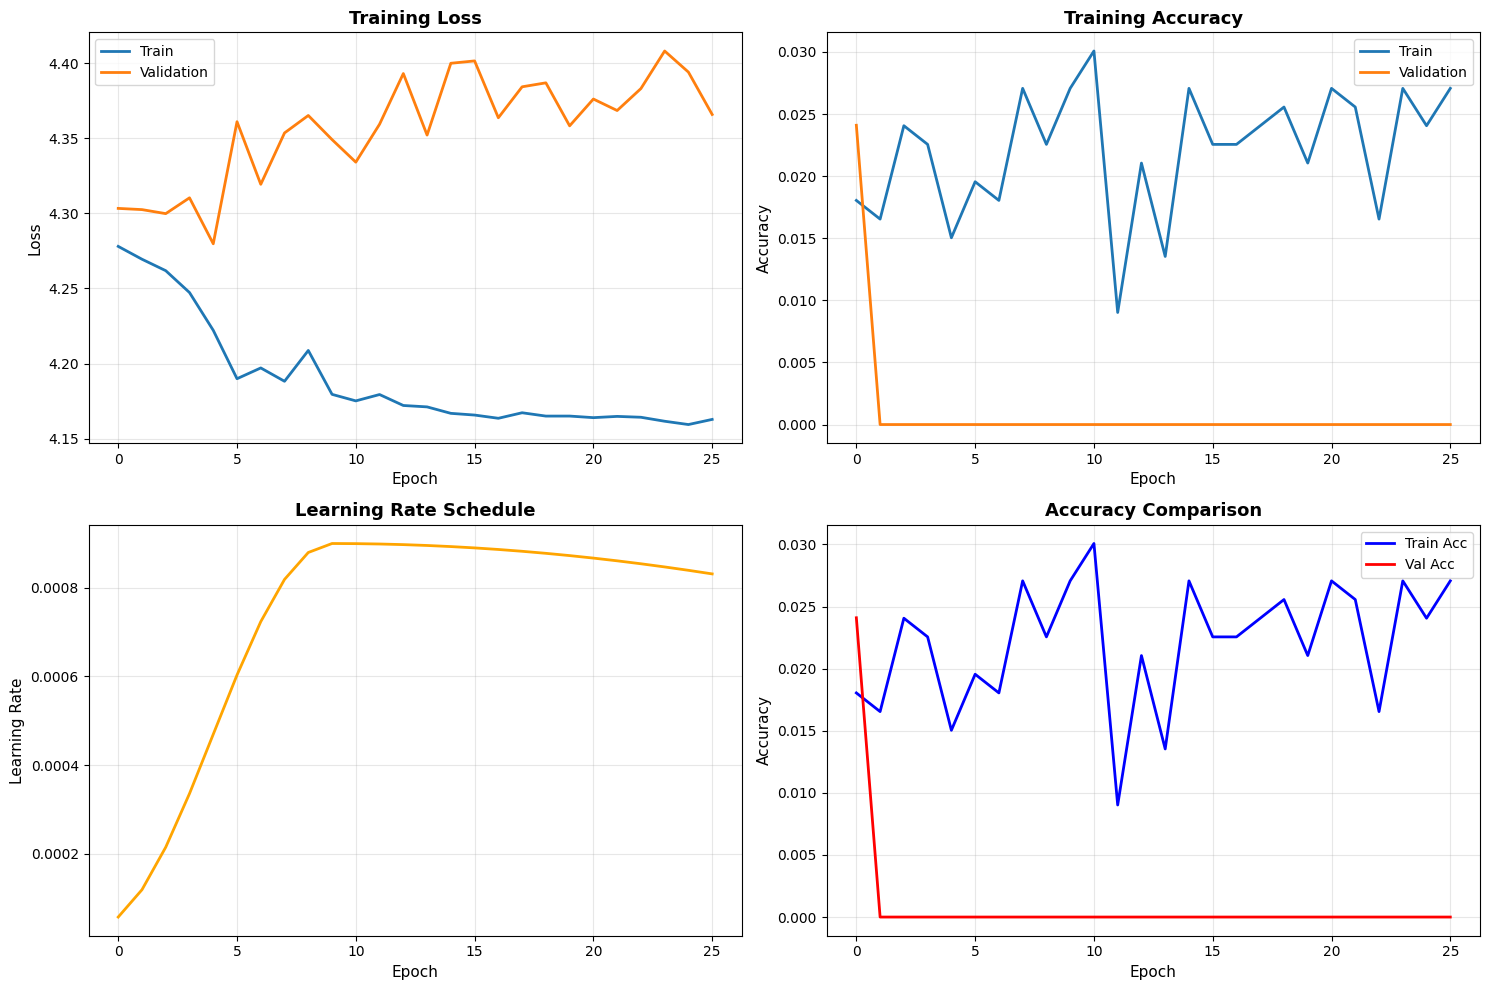

✅ Training curves saved and logged to WandB


In [35]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Training Loss', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Training Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Learning rate curve
axes[1, 0].plot(history['learning_rate'], linewidth=2, color='orange')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Learning Rate', fontsize=11)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Combined plot
ax4 = axes[1, 1]
ax4.plot(history['train_acc'], label='Train Acc', linewidth=2, color='blue')
ax4.plot(history['val_acc'], label='Val Acc', linewidth=2, color='red')
ax4.set_xlabel('Epoch', fontsize=11)
ax4.set_ylabel('Accuracy', fontsize=11)
ax4.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'training_curves': wandb.Image(str(checkpoint_dir / 'training_curves.png'))})

print(f"✅ Training curves saved and logged to WandB")

## Section 20: Top-5 Accuracy Analysis

In [36]:
# Calculate top-5 accuracy
def top_k_accuracy(labels, probs, k=5):
    """
    Calculate top-k accuracy
    Args:
        labels: true labels (batch_size,)
        probs: predicted probabilities (batch_size, num_classes)
        k: top-k to consider
    """
    top_k_preds = np.argsort(probs, axis=1)[:, -k:]
    correct = 0
    for i, label in enumerate(labels):
        if label in top_k_preds[i]:
            correct += 1
    return correct / len(labels)

# Calculate top-5 accuracy
all_probs_array = np.array(all_probs)
top5_acc = top_k_accuracy(all_labels, all_probs_array, k=5)

print(f"\n📊 Top-K Accuracy:")
print(f"{'='*50}")
print(f"Top-1 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Top-5 Accuracy: {top5_acc:.4f} ({top5_acc*100:.2f}%)")

# Log to WandB
wandb.log({
    'test/top5_accuracy': top5_acc
})

print(f"\n✅ Top-5 accuracy logged to WandB")


📊 Top-K Accuracy:
Top-1 Accuracy: 0.0000 (0.00%)
Top-5 Accuracy: 0.0238 (2.38%)

✅ Top-5 accuracy logged to WandB


## Section 21: Per-Class Analysis

In [37]:
# Calculate per-class accuracy
from collections import defaultdict

class_correct = defaultdict(int)
class_total = defaultdict(int)

for true_label, pred_label in zip(all_labels, all_predictions):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

per_class_accuracy = {}
for label_id in range(CONFIG['num_classes']):
    if class_total[label_id] > 0:
        per_class_accuracy[label_id] = class_correct[label_id] / class_total[label_id]
    else:
        per_class_accuracy[label_id] = 0.0

# Create DataFrame for easy analysis
class_df = pd.DataFrame([
    {'label_id': i, 'word': label_to_word[i], 'accuracy': per_class_accuracy[i], 
     'correct': class_correct[i], 'total': class_total[i]}
    for i in range(CONFIG['num_classes'])
])

# Sort by accuracy
class_df = class_df.sort_values('accuracy')

# Show worst and best performing classes
print(f"\n📊 Per-Class Analysis:")
print(f"{'='*70}")
print(f"\nWorst 5 performing classes:")
print(class_df.head(5).to_string(index=False))

print(f"\nBest 5 performing classes:")
print(class_df.tail(5)[::-1].to_string(index=False))


📊 Per-Class Analysis:

Worst 5 performing classes:
 label_id   word  accuracy  correct  total
        0   অবাক       0.0        0      0
        1   অর্থ       0.0        0      0
        2 অসুস্থ       0.0        0      0
        3   আমরা       0.0        0      0
        4    আমি       0.0        0      0

Best 5 performing classes:
 label_id    word  accuracy  correct  total
       71  হ্যালো       0.0        0      0
       70 হ্যালো       0.0        0      2
       69   হ্যাঁ       0.0        0      0
       68    হ্যা       0.0        0      2
       67  সুন্দর       0.0        0      5


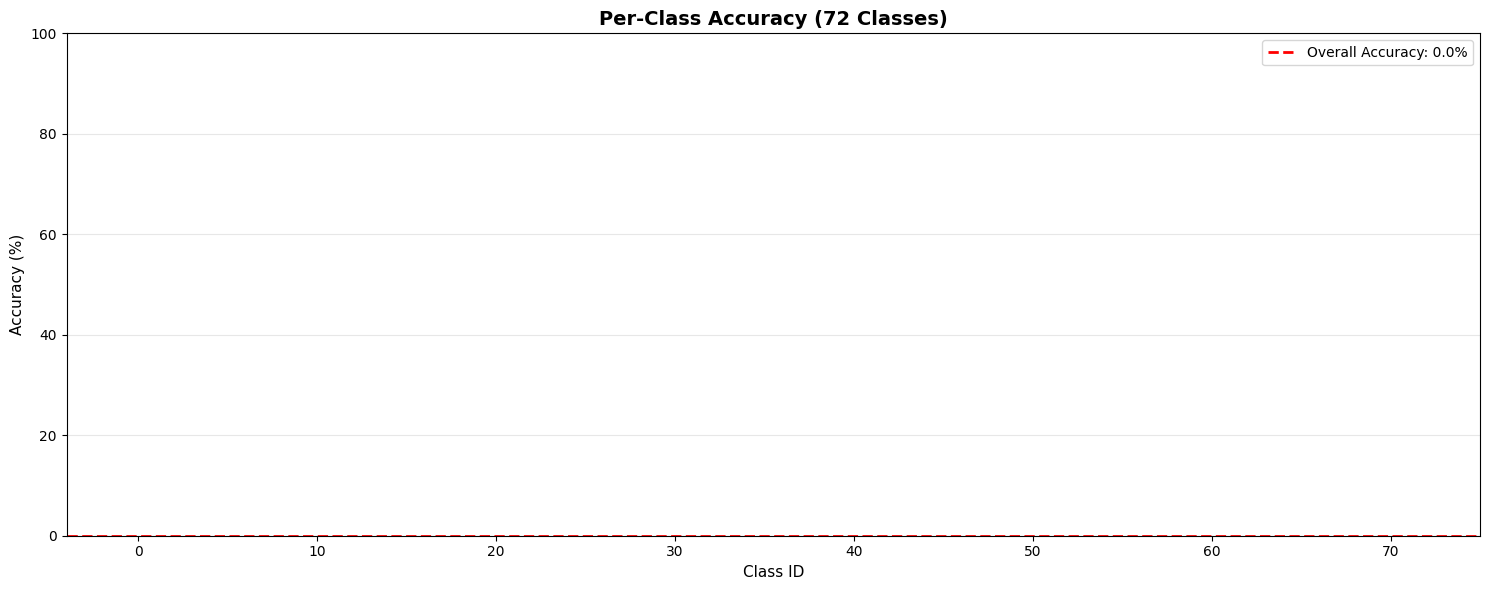

✅ Per-class accuracy plot saved and logged to WandB


In [38]:
# Plot per-class accuracy distribution
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(range(CONFIG['num_classes']), 
       [per_class_accuracy[i] * 100 for i in range(CONFIG['num_classes'])],
       color='steelblue', alpha=0.7)

ax.set_xlabel('Class ID', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Per-Class Accuracy (72 Classes)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=test_accuracy*100, color='red', linestyle='--', linewidth=2, label=f'Overall Accuracy: {test_accuracy*100:.1f}%')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'test/per_class_accuracy_plot': wandb.Image(str(checkpoint_dir / 'per_class_accuracy.png'))})

print(f"✅ Per-class accuracy plot saved and logged to WandB")

## Section 22: Save Final Results

In [39]:
# Save comprehensive test results
results = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1_score': float(test_f1),
    'test_top5_accuracy': float(top5_acc),
    'signer_accuracies': {k: float(v) for k, v in signer_accuracies.items()},
    'signer_counts': {k: int(v) for k, v in signer_counts.items()},
    'best_val_accuracy': float(best_val_acc),
    'best_epoch': int(checkpoint['epoch']),
    'total_epochs_trained': int(checkpoint['epoch']),
    'model_parameters': int(total_params),
    'config': CONFIG,
    'per_class_accuracy': {i: float(per_class_accuracy[i]) for i in range(CONFIG['num_classes'])}
}

with open(checkpoint_dir / 'test_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"✅ Test results saved to {checkpoint_dir / 'test_results.json'}")

# Also save as CSV for easy viewing
results_df = pd.DataFrame([
    {'Metric': 'Test Accuracy', 'Value': f"{test_accuracy:.4f} ({test_accuracy*100:.2f}%)"},
    {'Metric': 'Test Precision (macro)', 'Value': f"{test_precision:.4f} ({test_precision*100:.2f}%)"},
    {'Metric': 'Test Recall (macro)', 'Value': f"{test_recall:.4f} ({test_recall*100:.2f}%)"},
    {'Metric': 'Test F1-Score (macro)', 'Value': f"{test_f1:.4f} ({test_f1*100:.2f}%)"},
    {'Metric': 'Top-5 Accuracy', 'Value': f"{top5_acc:.4f} ({top5_acc*100:.2f}%)"},
    {'Metric': 'Best Val Accuracy', 'Value': f"{best_val_acc:.4f} ({best_val_acc*100:.2f}%)"},
    {'Metric': 'Best Epoch', 'Value': str(checkpoint['epoch'])},
    {'Metric': 'Total Parameters', 'Value': f"{total_params:,}"},
    {'Metric': 'Model Size (MB)', 'Value': f"{total_params * 4 / 1024**2:.2f}"},
])

results_df.to_csv(checkpoint_dir / 'test_results_summary.csv', index=False)
print(f"✅ Test results summary saved to {checkpoint_dir / 'test_results_summary.csv'}")

✅ Test results saved to /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints/test_results.json
✅ Test results summary saved to /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints/test_results_summary.csv


In [40]:
# Save final model
torch.save(model.state_dict(), checkpoint_dir / 'final_model.pth')
wandb.save(str(checkpoint_dir / 'final_model.pth'))

# Save model architecture summary
model_summary = {
    'architecture': 'ProductionSPOTER',
    'input_dim': CONFIG['input_dim'],
    'd_model': CONFIG['d_model'],
    'num_heads': CONFIG['num_heads'],
    'num_encoder_layers': CONFIG['num_encoder_layers'],
    'd_ff': CONFIG['d_ff'],
    'num_classes': CONFIG['num_classes'],
    'max_seq_length': CONFIG['seq_length'],
    'dropout': CONFIG['dropout'],
    'total_parameters': int(total_params),
    'trainable_parameters': int(trainable_params)
}

with open(checkpoint_dir / 'model_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=2)

print(f"✅ Final model saved to {checkpoint_dir / 'final_model.pth'}")
print(f"✅ Model summary saved to {checkpoint_dir / 'model_summary.json'}")

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


✅ Final model saved to /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints/final_model.pth
✅ Model summary saved to /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints/model_summary.json


## Section 23: WandB Finalization & Summary

In [41]:
# Log final artifacts to WandB
artifacts = [
    str(checkpoint_dir / 'best_model.pth'),
    str(checkpoint_dir / 'final_model.pth'),
    str(checkpoint_dir / 'label_mapping.json'),
    str(checkpoint_dir / 'test_results.json'),
    str(checkpoint_dir / 'model_summary.json'),
]

for artifact_path in artifacts:
    wandb.save(artifact_path)
    print(f"✅ Uploaded to WandB: {Path(artifact_path).name}")

# Finish WandB run
wandb.finish()
print(f"\n✅ WandB run completed successfully")

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


✅ Uploaded to WandB: best_model.pth
✅ Uploaded to WandB: final_model.pth
✅ Uploaded to WandB: label_mapping.json
✅ Uploaded to WandB: test_results.json
✅ Uploaded to WandB: model_summary.json


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate,▁▂▂▃▄▆▇▇████████████████▇▇
test/accuracy,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
test/top5_accuracy,▁
train/accuracy,▄▃▆▅▃▅▄▇▅▇█▁▅▂▇▅▅▆▇▅▇▇▃▇▆▇
train/loss,█▇▇▆▅▃▃▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...



✅ WandB run completed successfully


In [42]:
# Final summary
print(f"\n{'='*70}")
print(f"🎉 TRAINING COMPLETE - FINAL SUMMARY")
print(f"{'='*70}")

print(f"\n📁 Output Directory: {checkpoint_dir}")
print(f"\n📊 Test Results:")
print(f"   Top-1 Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Top-5 Accuracy:     {top5_acc:.4f} ({top5_acc*100:.2f}%)")
print(f"   Precision (macro):  {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"   Recall (macro):     {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"   F1-Score (macro):   {test_f1:.4f} ({test_f1*100:.2f}%)")

print(f"\n👥 Per-Signer Performance:")
for signer, acc in signer_accuracies.items():
    print(f"   {signer}: {acc:.4f} ({acc*100:.2f}%)")

print(f"\n🏋️  Model Information:")
print(f"   Architecture:      ProductionSPOTER")
print(f"   Total Parameters: {total_params:,}")
print(f"   Model Size:       {total_params * 4 / 1024**2:.2f} MB")
print(f"   Best Val Acc:     {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Best Epoch:       {checkpoint['epoch']}")

print(f"\n📦 Generated Files:")
output_files = [
    'best_model.pth',
    'final_model.pth',
    'label_mapping.json',
    'test_results.json',
    'test_results_summary.csv',
    'model_summary.json',
    'confusion_matrix.png',
    'confusion_matrix_normalized.png',
    'training_curves.png',
    'per_signer_accuracy.png',
    'per_class_accuracy.png',
    'signer_distribution.png',
    'grammar_distribution.png'
]

for file_name in output_files:
    file_path = checkpoint_dir / file_name
    if file_path.exists():
        file_size = file_path.stat().st_size
        size_mb = file_size / (1024 * 1024)
        print(f"   ✓ {file_name:45s} ({size_mb:6.2f} MB)")
    else:
        print(f"   ✗ {file_name:45s} (missing)")

print(f"\n🌐 WandB:")
print(f"   Project: bangla-sign-language-recognition")
print(f"   All metrics and artifacts logged")

print(f"\n{'='*70}")
print(f"🚀 Ready for inference and deployment!")
print(f"{'='*70}\n")


🎉 TRAINING COMPLETE - FINAL SUMMARY

📁 Output Directory: /home/raco/Repos/bangla-sign-language-recognition/Data/processed/new_model/checkpoints

📊 Test Results:
   Top-1 Accuracy:     0.0000 (0.00%)
   Top-5 Accuracy:     0.0238 (2.38%)
   Precision (macro):  0.0000 (0.00%)
   Recall (macro):     0.0000 (0.00%)
   F1-Score (macro):   0.0000 (0.00%)

👥 Per-Signer Performance:
   S05: 0.0000 (0.00%)

🏋️  Model Information:
   Architecture:      ProductionSPOTER
   Total Parameters: 1,303,786
   Model Size:       4.97 MB
   Best Val Acc:     0.0241 (2.41%)
   Best Epoch:       1

📦 Generated Files:
   ✓ best_model.pth                                ( 15.10 MB)
   ✓ final_model.pth                               (  5.07 MB)
   ✓ label_mapping.json                            (  0.00 MB)
   ✓ test_results.json                             (  0.00 MB)
   ✓ test_results_summary.csv                      (  0.00 MB)
   ✓ model_summary.json                            (  0.00 MB)
   ✓ confusion_mat